In [2]:
import numpy as np
from scipy.sparse import linalg as lg
import exact_diagonalization as ed
import utils
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import h5py

C:\Users\Stavros.SAVVAS-PROBOOK\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


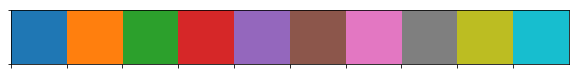

In [3]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 26

cp = sns.color_palette()
sns.palplot(cp)
plt.show()

Calculate overlaps between solving the Clock system and exact evolution for various $T$s

In [40]:
n_sites = 4
time_steps = 30
h_init = 1.0
h_ev = 0.5

t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]

ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

T_list = np.arange(20, 340, 20)
t_final_list = [1.0, 1.5, 2.0]

overlaps = []
for t_final in t_final_list:
    overlaps.append({"full": [], "averaged": []})
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
        clock = ed.construct_sparse_clock(ham, dt, time_steps)
        system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres, print_info=False)
        overlaps[-1]["full"].append(utils.overlap(exact_state, system_state))
        overlaps[-1]["averaged"].append(utils.averaged_overlap(exact_state, system_state))
        print(".", end="")
    for k in overlaps[-1].keys():
        overlaps[-1][k] = np.array(overlaps[-1][k])
    print()

................
................
................


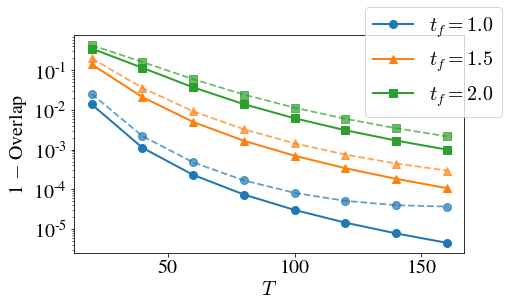

In [17]:
plt.figure(figsize=(7, 4))
markers = ["o", "^", "s"]
for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, 1 - overlaps[i]["averaged"], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t_f=%.1f$"%t_final)
    plt.semilogy(T_list, 1 - overlaps[i]["full"], "--", marker=markers[i], linewidth=1.8, markersize=8, color=cp[i], alpha=0.7)
plt.xlabel("$T$")
plt.ylabel("1 $-$ Overlap")
plt.legend(loc="lower left", bbox_to_anchor=(0.72, 0.58), fontsize=20)
plt.show()
#plt.savefig("ed_overlaps_steps.pdf", bbox_inches='tight')

In [41]:
plt.figure(figsize=(7, 4))
markers = ["o", "^", "s"]
for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, 1 - overlaps[i]["averaged"], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t_f=%.1f$"%t_final)
    plt.semilogy(T_list, 1 - overlaps[i]["full"], "--", marker=markers[i], linewidth=1.8, markersize=8, color=cp[i], alpha=0.7)
plt.xlabel("$T$")
plt.ylabel("1 $-$ Overlap")
plt.legend(loc="lower left", bbox_to_anchor=(0.72, 0.58), fontsize=22)
#plt.show()
plt.savefig("ed_overlaps_steps.pdf", bbox_inches='tight')

Calculate observables by solving the system

...

C:\Users\Stavros.SAVVAS-PROBOOK\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


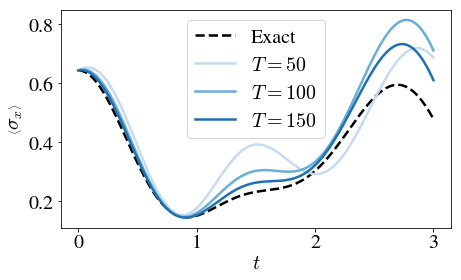

In [27]:
n_sites = 6
h_init = 1.0
h_ev = 0.5

ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
pauli = utils.Pauli(ham.dtype)

t_final = 3.0
exact_x = []
system_x = []
T_list = [50, 100, 150]
for time_steps in T_list:
    t = np.linspace(0.0, t_final, time_steps + 1)
    dt = t[1] - t[0]
    exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
    exact_x.append(obs["X"])

    clock = ed.construct_sparse_clock(ham, dt, time_steps)
    system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres, print_info=False)
    system_state *= 1.0 / np.sqrt((np.abs(system_state)**2).sum(axis=1))[:, np.newaxis]
    system_x.append(utils.ev_local(system_state, pauli.X))
    print(".", end="")

In [39]:
cseq = sns.color_palette("Blues", len(system_x))
plt.figure(figsize=(7, 4))
plt.plot(t, exact_x[-1], "--", color="black", linewidth=2.5, label="Exact")
for i, time_steps in enumerate(T_list):
     plt.plot(np.linspace(0.0, t_final, time_steps + 1), system_x[i], 
              linewidth=2.5, color=cseq[i], label="$T={}$".format(time_steps))
plt.xlabel("$t$")
plt.ylabel(r"$\left \langle \sigma _x\right \rangle$")
plt.legend(loc='center', bbox_to_anchor=(0.48, 0.75), fontsize=22)
#plt.show()
plt.savefig("sigma_x_system.pdf", bbox_inches='tight')

C:\Users\Stavros.SAVVAS-PROBOOK\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Solve eigenvalue problem for Clock with penalty term for the initial condition and check how it compares with exact evolution and the Clock system solution

In [19]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
time_steps = 20
penalty = 10.0

t = np.linspace(0.0, 3.0, time_steps + 1)
dt = t[1] - t[0]
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
clock = ed.construct_sparse_clock(ham, dt, time_steps)

clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
clock_pen = np.array(clock_pen.todense())

system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres)
eigvals, eigvecs = np.linalg.eigh(clock_pen)
eig_state = eigvecs[:, 0].reshape(exact_state.shape)

print("Penalty: {}".format(penalty))
print("\nSystem - Exact: {}".format(utils.averaged_overlap(exact_state, system_state)))
print("Eig - Exact: {}".format(utils.averaged_overlap(exact_state, eig_state)))
print("System - Eig: {}".format(utils.averaged_overlap(eig_state, system_state)))

clock_ev = lambda state: state.ravel().conj().dot(clock_pen.dot(state.ravel())) / (np.abs(state)**2).sum()
print("\nClock EVs:")
print("Exact: {}".format(clock_ev(exact_state)))
print("System: {}".format(clock_ev(system_state)))
print("Eig: {}".format(clock_ev(eig_state)))

Convergence status: 0
Penalty: 10.0

System - Exact: 0.5515175297584666
Eig - Exact: 6.0902642218166844e-24
System - Eig: 6.267117672764493e-24

Clock EVs:
Exact: (0.03478907027650905+1.0573552615477664e-17j)
System: (0.034707893080177125-2.765810748728232e-18j)
Eig: (0.005811628078718459-3.903127820947815e-18j)


Check how changing the penalty coefficient affects the overlap between exact and lowest eigenstate

In [4]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
time_steps = 60
penalty_list = np.linspace(1e-2, 10, 30)

t = np.linspace(0.0, 1.0, time_steps + 1)
dt = t[1] - t[0]
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)

overlaps = {"full": [], "averaged": []}
for penalty in penalty_list:
    clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
    clock_pen = np.array(clock_pen.todense())

    eigvals, eigvecs = np.linalg.eigh(clock_pen)
    eig_state = eigvecs[:, 0].reshape(exact_state.shape)
    
    overlaps["full"].append(utils.overlap(exact_state, eig_state))
    overlaps["averaged"].append(utils.averaged_overlap(exact_state, eig_state))
    print(".", end="")

for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])

..

KeyboardInterrupt: 

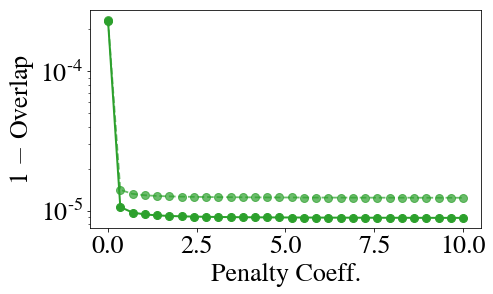

In [60]:
for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])
    n = len(overlaps[k])
    
plt.figure(figsize=(7, 4))
plt.semilogy(penalty_list[:n], 1 - overlaps["averaged"], marker="o", linewidth=2.0, markersize=8, color=cp[2])
plt.semilogy(penalty_list[:n], 1 - overlaps["full"], "--", marker="o", linewidth=1.8, markersize=8, color=cp[2], alpha=0.7)
plt.xlabel("Penalty Coeff.")
plt.ylabel("1 $-$ Overlap")
plt.show()

we see that if the penalty value is large enough, then it does not affect the physics. Hence, it is okay to use a large constant penalty.

Compare solving system, solving eigenvalue with penalty and optimizing

In [6]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
data_dir = "D:/DATA/ClockV2/histories"
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)

T_list = [20, 25, 30, 35]
overlaps = {"System": [], "Eig.": [], "Opt.": []}
for time_steps in T_list:
    t = np.linspace(0.0, 1.0, time_steps + 1)
    dt = t[1] - t[0]

    exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)
    
    clock = ed.construct_sparse_clock(ham, dt, time_steps)
    system_state = ed.solve_evolution_system(clock, exact_state[0], lg.gmres, print_info=False)
    overlaps["System"].append(utils.averaged_overlap(exact_state, system_state))
    
    clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=10.0, psi0=exact_state[0])
    clock_pen = np.array(clock_pen.todense())
    eigvals, eigvecs = np.linalg.eigh(clock_pen)
    eig_state = eigvecs[:, 0].reshape(exact_state.shape)
    overlaps["Eig."].append(utils.averaged_overlap(exact_state, eig_state))
    
    opt_hist = h5py.File("{}/N={}/allstates_fullwv_N{}M{}.h5py".format(data_dir, n_sites, n_sites, time_steps), "r")
    overlaps["Opt."].append(opt_hist["avg_overlaps"][-1])
    opt_hist.close()
    print(".", end="")

....

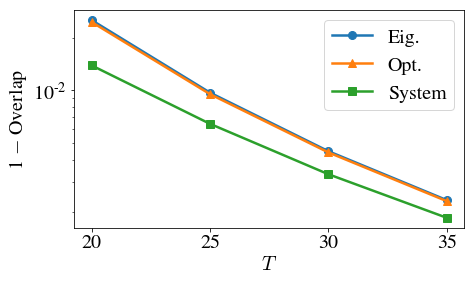

In [9]:
for k in overlaps.keys():
    overlaps[k] = np.array(overlaps[k])
    
plt.figure(figsize=(7, 4))
markers = ["o", "^", "s"]
for i, k in enumerate(overlaps.keys()):
    plt.semilogy(T_list, 1 - overlaps[k], marker=markers[i], linewidth=2.5, markersize=8, color=cp[i], label=k)
plt.xlabel("$T$")
plt.ylabel("1 $-$ Overlap")
plt.legend()
plt.show()

Check how the gap changes as a function of $T$ and $t$ for constant penalty. Notice that there is a **critical** $dt$ after which the system becomes "gapless" and solving the system or diagonalizing the Clock Hamiltonian does not give the correct evolution (we can check that by calculating the corresponding overlaps above).

In [37]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
t_final_list = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
T_list = np.arange(1, 20)
penalty = 1000.0

gaps = []
for t_final in t_final_list:
    gaps.append([])
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

        clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
        clock_pen = np.array(clock_pen.todense())

        eigvals = np.linalg.eigvalsh(clock_pen)
        gaps[-1].append(eigvals[1] - eigvals[0])

        print(".", end="")
    print()

...................
...................
...................
...................
...................
...................


For $N=4$ spins

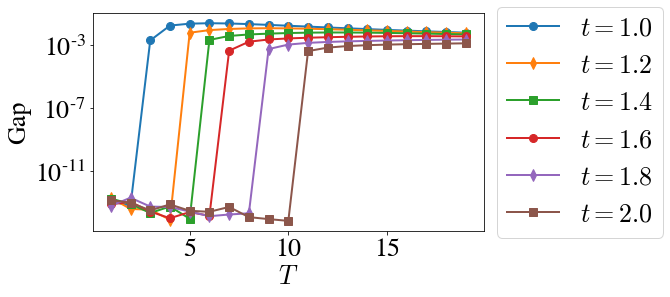

In [38]:
plt.figure(figsize=(7, 4))
markers = 3 * ["o", "d", "s"]

for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, gaps[i], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t=%.1f$"%t_final)
plt.xlabel("$T$")
plt.ylabel("Gap")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

For $N=6$ spins

...................
...................
...................
...................
...................
...................


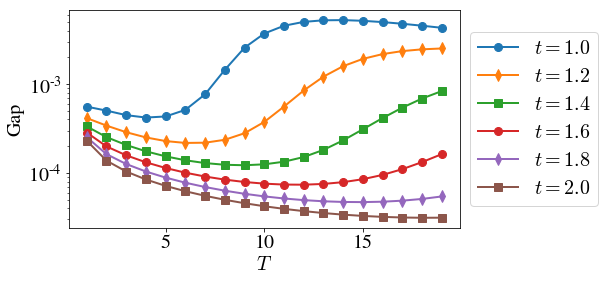

In [12]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
t_final_list = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
T_list = np.arange(1, 20)
penalty = 1000.0

gaps = []
for t_final in t_final_list:
    gaps.append([])
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

        clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
        clock_pen = np.array(clock_pen.todense())

        eigvals = np.linalg.eigvalsh(clock_pen)
        gaps[-1].append(eigvals[1] - eigvals[0])

        print(".", end="")
    print()
    
plt.figure(figsize=(7, 4))
markers = 3 * ["o", "d", "s"]

for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, gaps[i], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t=%.1f$"%t_final)
plt.xlabel("$T$")
plt.ylabel("Gap")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

For $N=6$ spins

.....
.....
.....
.....
.....
.....


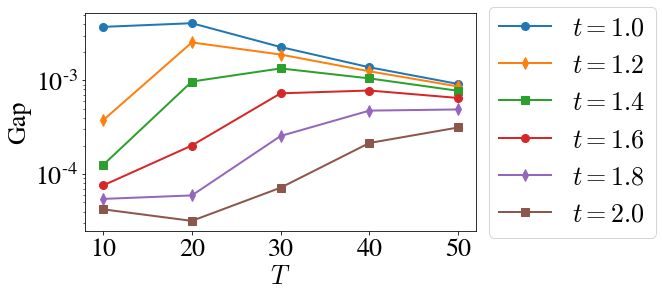

In [8]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
t_final_list = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
T_list = np.arange(10, 51, 10)
penalty = 1000.0
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)

gaps = []
for t_final in t_final_list:
    gaps.append([])
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

        clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
        clock_pen = np.array(clock_pen.todense())

        eigvals = np.linalg.eigvalsh(clock_pen)
        gaps[-1].append(eigvals[1] - eigvals[0])

        print(".", end="")
    print()
    
plt.figure(figsize=(7, 4))
markers = 3 * ["o", "d", "s"]

for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, gaps[i], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t=%.1f$"%t_final)
plt.xlabel("$T$")
plt.ylabel("Gap")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [44]:
n_sites = 4
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)
time_steps = 20
t = np.linspace(0.0, 1.0, 21)
dt = t[1] - t[0]
exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

clock_pen = ed.construct_sparse_clock(ham, dt, 20, init_penalty=100.0, psi0=exact_state[0])
clock_pen = np.array(clock_pen.todense())

eigvals, eigstates = np.linalg.eigh(clock_pen)
eigvals[:10]

ground = eigstates[:, 0].reshape(exact_state.shape)
ground *= 1.0 / np.sqrt((np.abs(ground)**2).sum(axis=1)[:, np.newaxis])

excited = eigstates[:, 1].reshape(exact_state.shape)
excited *= 1.0 / np.sqrt((np.abs(excited)**2).sum(axis=1)[:, np.newaxis])

In [45]:
print(utils.averaged_overlap(ground, exact_state))
print(utils.averaged_overlap(excited, exact_state))

0.999241683539311
1.0757720148179126e-20


1.0757720148179126e-20

Repeat the same plot but for proper $dt$s so that the method works well

..........
..........
..........
..........
..........


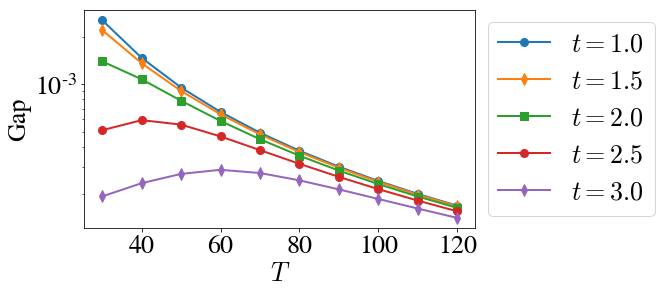

In [40]:
n_sites = 4
h_init = 1.0
h_ev = 0.5
t_final_list = [1.0, 1.5, 2.0, 2.5, 3.0]
T_list = np.arange(30, 130, 10)
penalty = 10.0

gaps = []
for t_final in t_final_list:
    gaps.append([])
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

        clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
        clock_pen = np.array(clock_pen.todense())

        eigvals = np.linalg.eigvalsh(clock_pen)
        gaps[-1].append(eigvals[1] - eigvals[0])

        print(".", end="")
    print()
    
plt.figure(figsize=(7, 4))
markers = 3 * ["o", "d", "s"]

for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, gaps[i], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t_f=%.1f$"%t_final)
plt.xlabel("$T$")
plt.ylabel("Gap")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [13]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
t_final_list = [1.0, 1.5, 2.0, 2.5, 3.0]
T_list = np.arange(30, 110, 10)
penalty = 10.0

gaps = []
for t_final in t_final_list:
    gaps.append([])
    for time_steps in T_list:
        t = np.linspace(0.0, t_final, time_steps + 1)
        dt = t[1] - t[0]
        exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

        clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
        clock_pen = np.array(clock_pen.todense())

        eigvals = np.linalg.eigvalsh(clock_pen)
        gaps[-1].append(eigvals[1] - eigvals[0])

        print(".", end="")
    print()
    
plt.figure(figsize=(7, 4))
markers = 3 * ["o", "d", "s"]

for i, t_final in enumerate(t_final_list):
    plt.semilogy(T_list, gaps[i], marker=markers[i], linewidth=2.0, markersize=8, color=cp[i], label="$t_f=%.1f$"%t_final)
plt.xlabel("$T$")
plt.ylabel("Gap")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

..

KeyboardInterrupt: 

..............................

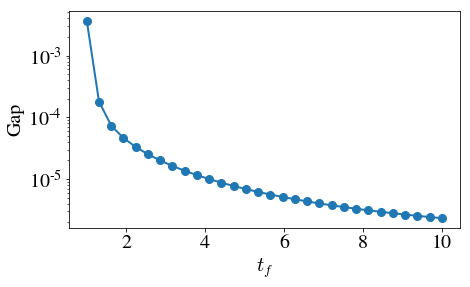

In [11]:
n_sites = 6
h_init = 1.0
h_ev = 0.5
penalty = 100.0
time_steps = 10
t_final_list = np.linspace(1.0, 10.0, 30)
ham = utils.tfim_hamiltonian(n_sites, h=h_ev)

gaps = []
for t_final in t_final_list:
    t = np.linspace(0.0, t_final, time_steps + 1)
    dt = t[1] - t[0]
    exact_state, obs = utils.tfim_exact_evolution(n_sites, t[-1], time_steps, h0=h_init, h=h_ev)

    clock_pen = ed.construct_sparse_clock(ham, dt, time_steps, init_penalty=penalty, psi0=exact_state[0])
    clock_pen = np.array(clock_pen.todense())

    eigvals = np.linalg.eigvalsh(clock_pen)
    gaps.append(eigvals[1] - eigvals[0])

    print(".", end="")
    
plt.figure(figsize=(7, 4))
plt.semilogy(t_final_list, gaps, marker="o", linewidth=2.0, markersize=8, color=cp[0])
plt.xlabel("$t_f$")
plt.ylabel("Gap")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()